In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Data Loading

In [0]:
downloaded_train = drive.CreateFile({'id':"1Xq0gPPovqWmyVrTu2VHPDpewgGlRkyTW"})  
downloaded_train.GetContentFile('train_machine.csv')


In [0]:
downloaded_train = drive.CreateFile({'id':"1JBPXdfv7mem1s0x4IZelzLMOH9w4zYzR"})   
downloaded_train.GetContentFile('test_machine.csv')


In [0]:
dataset = pd.read_csv('train_machine.csv')

In [7]:
print(dataset.head())
print(dataset.describe())

  MachineID MachineModel  ...  Sensor4_mean      ActionPoint
0  MID11001       model4  ...         40.33  ComponentRepair
1  MID11002       model1  ...         40.49  ComponentRepair
2  MID11003       model3  ...         40.54          NoIssue
3  MID11004       model4  ...         40.59          NoIssue
4  MID11005       model3  ...         40.57  ComponentRepair

[5 rows x 38 columns]
       ServicePeriod  error1_avg  ...  Sensor3_mean  Sensor4_mean
count     674.000000  674.000000  ...    674.000000    674.000000
mean       13.091988   44.113991  ...    100.842478     40.365356
std         5.288455   34.573864  ...      0.283153      0.125382
min         3.000000    0.000000  ...    100.240000     40.090000
25%         9.000000    5.225000  ...    100.650000     40.270000
50%        13.000000   45.000000  ...    100.770000     40.340000
75%        18.000000   65.732500  ...    100.990000     40.460000
max        22.000000  147.380000  ...    101.660000     40.680000

[8 rows x 29 col

#1. Preprocessing

In [0]:
dataset.drop(labels='MachineID', axis=1, inplace=True)

In [9]:
dataset.isnull().sum(axis=0)

MachineModel                   0
ServicePeriod                  0
error1_avg                     0
error2_avg                     0
error3_avg                     0
error4_avg                     0
error5_avg                     0
Comp_Timelapse_diff_errors     0
RecentError                    0
MostOccuredError               0
comp_1_replace_avg             0
comp_2_replace_avg             0
comp_3_replace_avg             0
comp_4_replace_avg             0
Comp_Timelapse_diff_replace    0
RecentReplacedComp             0
MostReplacedComp               0
comp1_repair_avg               0
comp2_repair_avg               0
comp3_repair_avg               0
comp4_repair_avg               0
Comp_Timelapse_diff_repair     0
RecentRepaired                 0
MostRepairedComponent          0
Sensor1_max                    0
Sensor2_max                    0
Sensor3_max                    0
Sensor4_max                    0
Sensor1_min                    0
Sensor2_min                    0
Sensor3_mi

In [0]:
columns = dataset.columns
cat_attr = ['MachineModel', 'RecentError', 'MostOccuredError', 'RecentReplacedComp', 'MostReplacedComp', 'RecentRepaired', 'MostRepairedComponent', 'ActionPoint']
#num_attr = ['tenure', 'MonthlyCharges', 'TotalCharges']
num_attr = list(set(columns) - set(cat_attr))

In [11]:
print("The total columns in the dataset are {}".format(len(columns)))
print("The numerical columns in the dataset are {}".format(len(num_attr)))
print("The categorical columns in the dataset are {}".format(len(cat_attr)))

The total columns in the dataset are 37
The numerical columns in the dataset are 29
The categorical columns in the dataset are 8


In [12]:
dataset[num_attr] = dataset[num_attr].apply(lambda x: x.astype('float64'))
dataset[cat_attr] = dataset[cat_attr].apply(lambda x: x.astype('category'))
print(dataset.dtypes)

MachineModel                   category
ServicePeriod                   float64
error1_avg                      float64
error2_avg                      float64
error3_avg                      float64
error4_avg                      float64
error5_avg                      float64
Comp_Timelapse_diff_errors      float64
RecentError                    category
MostOccuredError               category
comp_1_replace_avg              float64
comp_2_replace_avg              float64
comp_3_replace_avg              float64
comp_4_replace_avg              float64
Comp_Timelapse_diff_replace     float64
RecentReplacedComp             category
MostReplacedComp               category
comp1_repair_avg                float64
comp2_repair_avg                float64
comp3_repair_avg                float64
comp4_repair_avg                float64
Comp_Timelapse_diff_repair      float64
RecentRepaired                 category
MostRepairedComponent          category
Sensor1_max                     float64


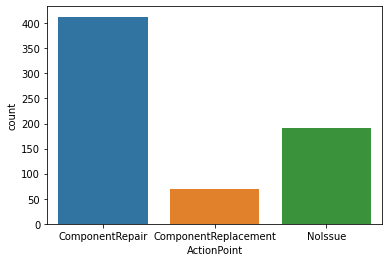

In [13]:
sns.countplot(x='ActionPoint', data=dataset)
plt.show()

In [0]:
lab_enc = LabelEncoder()
lab_enc.fit(dataset['ActionPoint'])
dataset['ActionPoint'] = lab_enc.transform(dataset['ActionPoint'])

In [15]:
dataset['ActionPoint'].value_counts()

0    413
2    191
1     70
Name: ActionPoint, dtype: int64

In [16]:
labels = dataset['ActionPoint']
print(len(labels))
dataset.drop(labels='ActionPoint', axis=1, inplace=True)

674


In [17]:
print(list(set(cat_attr)-set(['ActionPoint'])))
print(cat_attr)

['RecentRepaired', 'MostRepairedComponent', 'MachineModel', 'MostOccuredError', 'MostReplacedComp', 'RecentReplacedComp', 'RecentError']
['MachineModel', 'RecentError', 'MostOccuredError', 'RecentReplacedComp', 'MostReplacedComp', 'RecentRepaired', 'MostRepairedComponent', 'ActionPoint']


In [18]:
dataset_dumm = pd.get_dummies(data=dataset, columns=list(set(cat_attr)-set(['ActionPoint'])))
dataset_dumm.columns

Index(['ServicePeriod', 'error1_avg', 'error2_avg', 'error3_avg', 'error4_avg',
       'error5_avg', 'Comp_Timelapse_diff_errors', 'comp_1_replace_avg',
       'comp_2_replace_avg', 'comp_3_replace_avg', 'comp_4_replace_avg',
       'Comp_Timelapse_diff_replace', 'comp1_repair_avg', 'comp2_repair_avg',
       'comp3_repair_avg', 'comp4_repair_avg', 'Comp_Timelapse_diff_repair',
       'Sensor1_max', 'Sensor2_max', 'Sensor3_max', 'Sensor4_max',
       'Sensor1_min', 'Sensor2_min', 'Sensor3_min', 'Sensor4_min',
       'Sensor1_mean', 'Sensor2_mean', 'Sensor3_mean', 'Sensor4_mean',
       'RecentRepaired_Component1', 'RecentRepaired_Component2',
       'RecentRepaired_Component3', 'RecentRepaired_Component4',
       'MostRepairedComponent_Component1', 'MostRepairedComponent_Component2',
       'MostRepairedComponent_Component3', 'MostRepairedComponent_Component4',
       'MachineModel_model1', 'MachineModel_model2', 'MachineModel_model3',
       'MachineModel_model4', 'MostOccuredError_er

# Preprocessing test data

In [0]:
test = pd.read_csv('test_machine.csv')

test_machineID = test.MachineID.tolist()
test.drop(labels='MachineID', axis=1, inplace=True)

test_columns = dataset.columns
test_cat_attr = ['MachineModel', 'RecentError', 'MostOccuredError', 'RecentReplacedComp', 'MostReplacedComp', 'RecentRepaired', 'MostRepairedComponent']
#num_attr = ['tenure', 'MonthlyCharges', 'TotalCharges']
test_num_attr = list(set(test_columns) - set(test_cat_attr))

In [0]:
test[test_num_attr] = dataset[test_num_attr].apply(lambda x: x.astype('float64'))
test[test_cat_attr] = dataset[test_cat_attr].apply(lambda x: x.astype('category'))

In [0]:
test_dumm = pd.get_dummies(data=test, columns=test_cat_attr)

# 2. Modelling




### ***Approach 1***

1. Gradient Boost 
2. AdaBoost
3. Logistic Regression
4. SVM (radial,linear)
5. SC
6. Random Forest

# Gradient Boost

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataset_dumm, labels, test_size=0.4, stratify=labels, random_state=0)

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
#Setting up pipeline
steps = [('scaler', StandardScaler()),
         ('SGBT', GradientBoostingClassifier())]
pipeline = Pipeline(steps)

In [0]:
#Setting params grid for hyper param tuning
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)
param_grid = {'SGBT__max_depth': [3,5, 6,7,8], 'SGBT__subsample': [0.8, 0.7, 0.6,], 'SGBT__max_features':[0.2, 0.3], 
              'SGBT__n_estimators': [10, 20, 30]}
sgbt_cv = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold)

In [24]:
sgbt_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SGBT',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                      

In [0]:
sgbt_cv_best = sgbt_cv.best_estimator_
y_pred = sgbt_cv_best.predict(X_test)

In [26]:
print("Accuracy: {}".format(sgbt_cv_best.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Best Parameters: {}".format(sgbt_cv.best_params_))
print("Tuned Model Best Score: {}".format(sgbt_cv.best_score_))

Accuracy: 0.6444444444444445
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       165
           1       0.67      0.07      0.13        28
           2       0.58      0.27      0.37        77

    accuracy                           0.64       270
   macro avg       0.63      0.42      0.42       270
weighted avg       0.63      0.64      0.59       270

Tuned Model Best Parameters: {'SGBT__max_depth': 7, 'SGBT__max_features': 0.3, 'SGBT__n_estimators': 30, 'SGBT__subsample': 0.8}
Tuned Model Best Score: 0.6608641975308642


# Ada Boost

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [29]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3), n_estimators=500, learning_rate=0.3, algorithm= 'SAMME', random_state=143)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [30]:
y_pred_ada = ada_clf.predict(X_test)
print(classification_report(y_test,y_pred_ada))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76       165
           1       0.40      0.29      0.33        28
           2       0.62      0.49      0.55        77

    accuracy                           0.67       270
   macro avg       0.58      0.53      0.55       270
weighted avg       0.65      0.67      0.65       270



# Logistic Regression

In [0]:
logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs")
logreg.fit(X_train, y_train)

In [43]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.62


In [44]:
confmatrix = confusion_matrix(y_test, y_pred)
print(confmatrix)

[[137   8  20]
 [ 21   4   3]
 [ 51   0  26]]


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.83      0.73       165
           1       0.33      0.14      0.20        28
           2       0.53      0.34      0.41        77

    accuracy                           0.62       270
   macro avg       0.51      0.44      0.45       270
weighted avg       0.59      0.62      0.59       270



In [0]:
#Setting params grid for hyper param tuning
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=143)
param_grid = {'C': [0.05, 0.06, 0.07, 0.08, 0.1]}
log_reg1 = LogisticRegression(multi_class="multinomial", solver="lbfgs", )
log_reg_cv = GridSearchCV(log_reg1, param_grid, cv=kfold, scoring='accuracy')

In [0]:
log_reg_cv.fit(X_train, y_train)
log_reg_cv_best = log_reg_cv.best_estimator_

In [48]:
y_pred = log_reg_cv_best.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(log_reg_cv_best.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.61


In [49]:
print(confusion_matrix(y_test, y_pred))

[[140   7  18]
 [ 23   3   2]
 [ 55   0  22]]


In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       165
           1       0.30      0.11      0.16        28
           2       0.52      0.29      0.37        77

    accuracy                           0.61       270
   macro avg       0.49      0.41      0.42       270
weighted avg       0.57      0.61      0.57       270



# SVM

In [0]:
from sklearn.svm import SVC
svm = SVC() #default rbf kernel


In [0]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [58]:
print("The accuracy of the svc is {:.2f}".format(svm.score(X_test,y_test)))

The accuracy of the svc is 0.61


In [59]:
print(confusion_matrix(y_test, y_pred))

[[165   0   0]
 [ 28   0   0]
 [ 77   0   0]]


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       165
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        77

    accuracy                           0.61       270
   macro avg       0.20      0.33      0.25       270
weighted avg       0.37      0.61      0.46       270



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
#Setting up pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]
pipeline = Pipeline(steps)

In [0]:
#Setting params grid for hyper param tuning
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)
param_grid = {'SVM__C': [50, 60, 70, 80, 90], 'SVM__gamma': [0.008, 0.003, 0.001], 'SVM__kernel':['rbf'], 
              'SVM__class_weight':[{0:0.3, 1:2, 2:0.6}]}
svm_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold)

In [64]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None

In [0]:
svm_cv_best = svm_grid.best_estimator_
y_pred = svm_cv_best.predict(X_test)

In [66]:
print("Accuracy: {}".format(svm_cv_best.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Best Parameters: {}".format(svm_grid.best_params_))
print("Tuned Model Best Score: {}".format(svm_grid.best_score_))

Accuracy: 0.5925925925925926
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       165
           1       0.26      0.18      0.21        28
           2       0.47      0.39      0.43        77

    accuracy                           0.59       270
   macro avg       0.47      0.44      0.45       270
weighted avg       0.57      0.59      0.58       270

Tuned Model Best Parameters: {'SVM__C': 50, 'SVM__class_weight': {0: 0.3, 1: 2, 2: 0.6}, 'SVM__gamma': 0.008, 'SVM__kernel': 'rbf'}
Tuned Model Best Score: 0.5691975308641976


# Linear SVM

In [0]:
from sklearn.svm import LinearSVC

In [0]:
#linear_svm = LinearSVC(random_state=143, C=10) #OneVsRestClassifier()
steps_linear = [('scaler', StandardScaler()),
         ('SVM_linear', LinearSVC())]
pipeline_linear = Pipeline(steps_linear)

#Setting params grid for hyper param tuning
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=143)
param_grid_linear = {'SVM__C': [20, 30]}
linear_svm = GridSearchCV(pipeline, param_grid=param_grid_linear, cv=kfold)

In [69]:
linear_svm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=143, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None

In [0]:
y_pred_linear = linear_svm.predict(X_test)

In [71]:
print("Accuracy: {}".format(linear_svm.score(X_test, y_test)))
print(classification_report(y_test, y_pred_linear))
print("Tuned Model Best Parameters: {}".format(linear_svm.best_params_))
print("Tuned Model Best Score: {}".format(linear_svm.best_score_))

Accuracy: 0.6185185185185185
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       165
           1       0.38      0.11      0.17        28
           2       0.48      0.38      0.42        77

    accuracy                           0.62       270
   macro avg       0.51      0.43      0.44       270
weighted avg       0.59      0.62      0.59       270

Tuned Model Best Parameters: {'SVM__C': 20}
Tuned Model Best Score: 0.5866622768510389


# SG Classifier

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
steps_sgc = [('scaler', StandardScaler()),
         ('SGC', SGDClassifier(n_jobs=-1, random_state=143))]
pipeline_sgc = Pipeline(steps_sgc)

#Setting params grid for hyper param tuning
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=143)
param_grid_sgc = {'SGC__loss':['modified_huber'], 'SGC__penalty': ['elasticnet'], 'SGC__alpha': [0.2,0.3],
                     'SGC__l1_ratio': [0.1], 'SGC__max_iter': [70], 'SGC__learning_rate': ['optimal'], 
                     'SGC__eta0': [0.1], 'SGC__class_weight': [{0:0.3, 1:3, 2:0.6}]}
sgc_cv = GridSearchCV(pipeline_sgc, param_grid=param_grid_sgc, cv=kfold)

In [77]:
sgc_cv.fit(X_train, y_train)
sgc_cv_best = sgc_cv.best_estimator_
y_pred_sgc = sgc_cv_best.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [78]:
print("Accuracy: {}".format(sgc_cv_best.score(X_test, y_test)))
print(classification_report(y_test, y_pred_sgc))
print("Tuned Model Best Parameters: {}".format(sgc_cv.best_params_))
print("Tuned Model Best Score: {}".format(sgc_cv.best_score_))

Accuracy: 0.5444444444444444
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       165
           1       0.23      0.46      0.31        28
           2       0.53      0.39      0.45        77

    accuracy                           0.54       270
   macro avg       0.47      0.49      0.47       270
weighted avg       0.58      0.54      0.56       270

Tuned Model Best Parameters: {'SGC__alpha': 0.2, 'SGC__class_weight': {0: 0.3, 1: 3, 2: 0.6}, 'SGC__eta0': 0.1, 'SGC__l1_ratio': 0.1, 'SGC__learning_rate': 'optimal', 'SGC__loss': 'modified_huber', 'SGC__max_iter': 70, 'SGC__penalty': 'elasticnet'}
Tuned Model Best Score: 0.5594088381621305


# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf_grid = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=5, n_jobs=-1, random_state=153, verbose=1,class_weight=None)

In [154]:
rf_grid.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=153, verbose=1,
                       warm_start=False)

In [155]:
y_preds = rf_grid.predict(X_test)
print(rf_grid.score(X_test,y_test))
print(classification_report(y_test, y_preds))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


0.6555555555555556
              precision    recall  f1-score   support

           0       0.66      0.89      0.76       165
           1       0.00      0.00      0.00        28
           2       0.62      0.39      0.48        77

    accuracy                           0.66       270
   macro avg       0.43      0.43      0.41       270
weighted avg       0.58      0.66      0.60       270



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


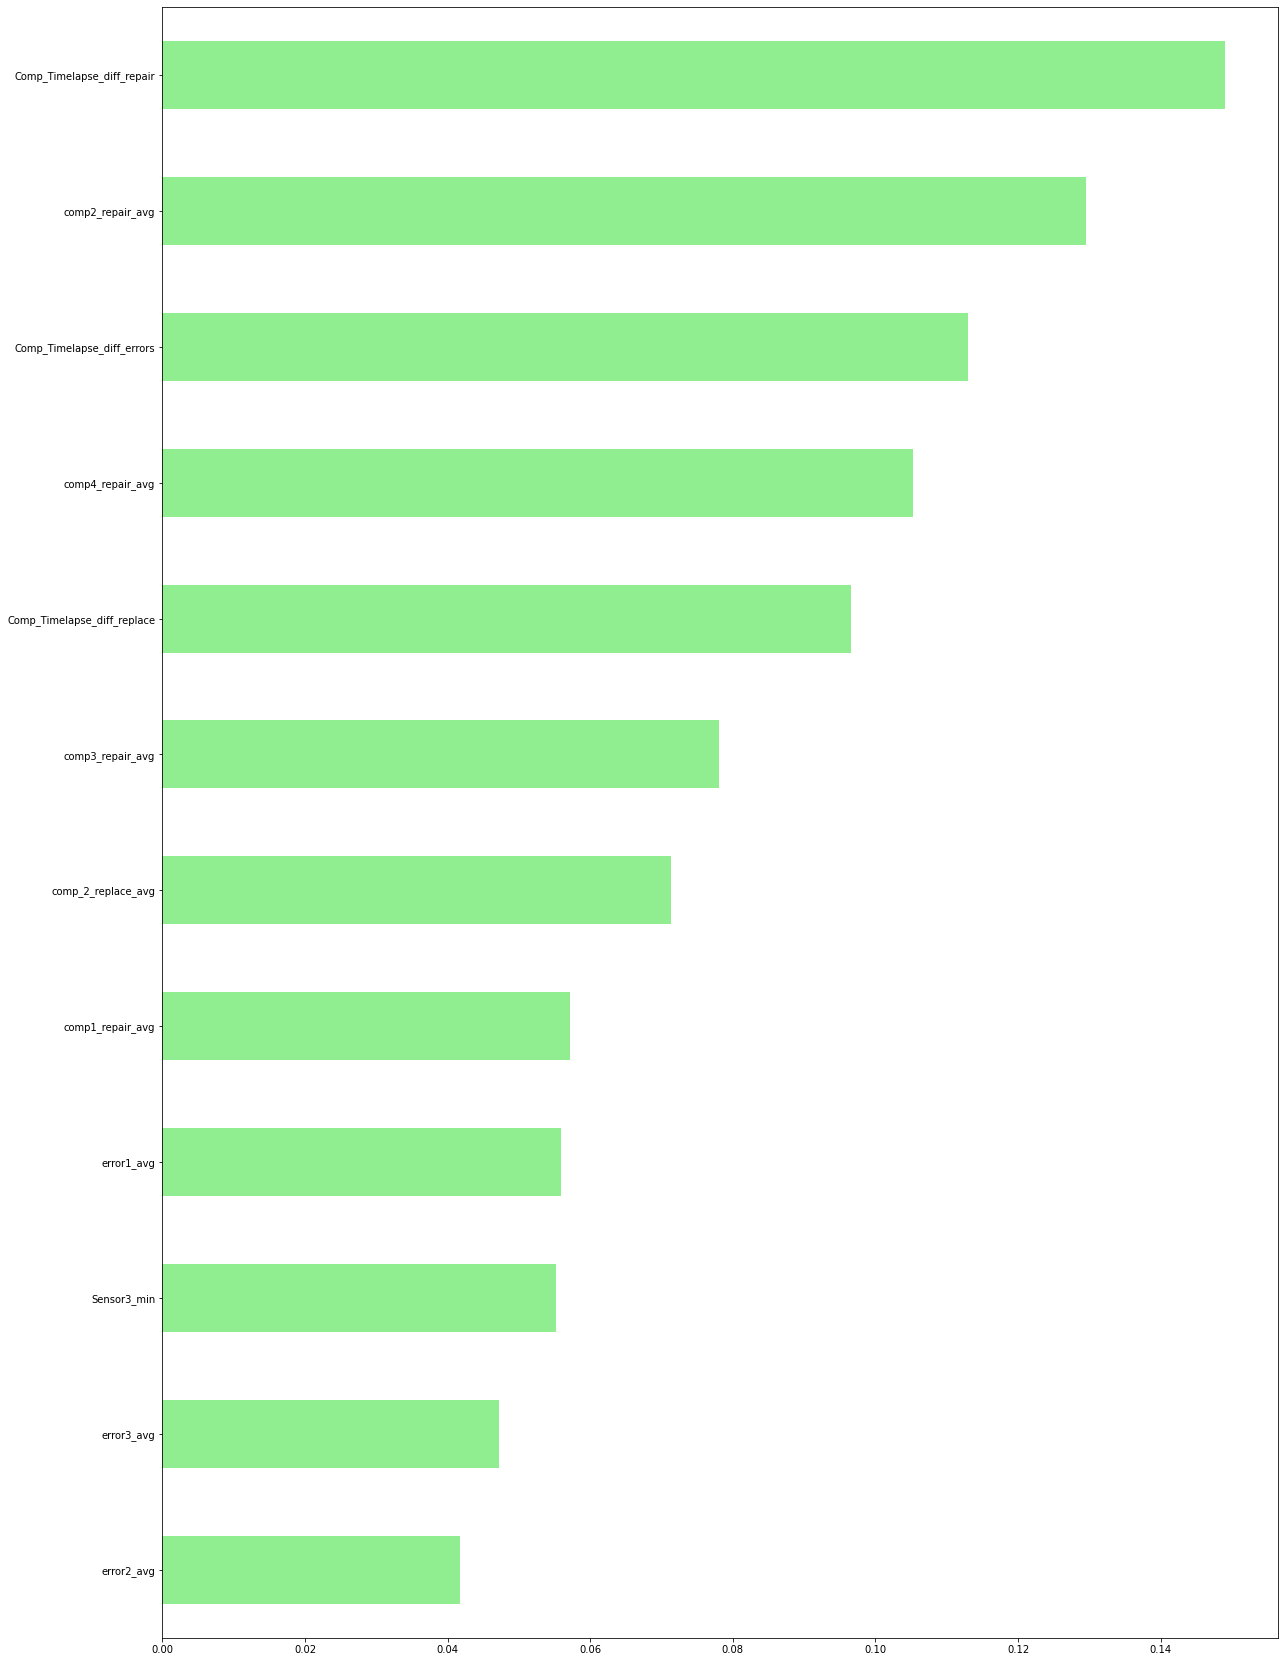

In [156]:
importances_rf = pd.Series(rf_grid.feature_importances_,index = X_train.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh',color='lightgreen')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
#plt.figure(figsize=(160,500))
plt.show()

In [157]:
# using variable imp features
sorted_importances_rf.sort_values(ascending=False, inplace=True)
print(sorted_importances_rf[:10])
print(type(sorted_importances_rf))

Comp_Timelapse_diff_repair     0.149045
comp2_repair_avg               0.129552
Comp_Timelapse_diff_errors     0.113019
comp4_repair_avg               0.105218
Comp_Timelapse_diff_replace    0.096586
comp3_repair_avg               0.078030
comp_2_replace_avg             0.071358
comp1_repair_avg               0.057110
error1_avg                     0.055853
Sensor3_min                    0.055159
dtype: float64
<class 'pandas.core.series.Series'>


In [158]:
imp_features = list(sorted_importances_rf.index.values[:12])
dataset_imp = dataset_dumm[imp_features]
dataset_imp.head(5)

,Comp_Timelapse_diff_repair,comp2_repair_avg,Comp_Timelapse_diff_errors,comp4_repair_avg,Comp_Timelapse_diff_replace,comp3_repair_avg,comp_2_replace_avg,comp1_repair_avg,error1_avg,Sensor3_min,error3_avg,error2_avg
0,14.47,32.91,13.58,87.80,25.91,47.00,47.5,43.50,60.00,61.86,40.71,35.65
1,16.17,78.67,31.50,31.86,42.86,38.82,150.0,76.00,0.00,62.02,150.00,150.00
2,15.52,43.67,27.27,46.89,42.86,47.57,135.0,72.83,37.50,51.25,93.54,90.00
3,17.50,43.25,18.53,50.88,39.38,54.75,105.0,63.00,42.41,61.19,78.75,78.75
4,15.41,29.40,19.02,40.64,28.12,54.50,30.0,57.43,44.21,64.10,33.24,96.44


In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataset_imp, labels, test_size=0.4, stratify=labels, random_state=1234)

In [0]:
rf_imp = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=5, random_state=153, class_weight={0:0.3, 1:2, 2:.7})

In [0]:
rf_imp.fit(X_train,y_train)
y_preds = rf_imp.predict(X_test)

In [162]:
print(rf_imp.score(X_test,y_test))
print(classification_report(y_test, y_preds))

0.6111111111111112
              precision    recall  f1-score   support

           0       0.74      0.60      0.66       165
           1       0.46      0.43      0.44        28
           2       0.49      0.70      0.58        77

    accuracy                           0.61       270
   macro avg       0.56      0.58      0.56       270
weighted avg       0.64      0.61      0.62       270



### ***Approach 2***

# Clustering and Stacking

splitting data into 3 clusters with abundant data

In [0]:
dataset_dumm['target'] = labels

imbal_data = dataset_dumm[dataset_dumm.target == 1]
abn_data = dataset_dumm[dataset_dumm.target != 1]

In [168]:
abn_target = abn_data['target']
abn_data.drop('target', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
std_scale = StandardScaler()
abn_data_std = std_scale.fit_transform(abn_data)

In [0]:
from sklearn.cluster import KMeans
clt = KMeans(n_clusters=3, random_state=0)

clt_model = clt.fit(abn_data)

In [0]:
clt_labels = clt_model.labels_
abn_data['clt_labels'] = clt_labels

In [0]:
clt0_data = abn_data[abn_data['clt_labels'] == 0]
clt1_data = abn_data[abn_data['clt_labels'] == 1]
clt2_data = abn_data[abn_data['clt_labels'] == 2]

In [0]:
imbal_data['clt_labels'] = imbal_data['target']
imbal_data.drop('target', axis=1, inplace=True)
imbal_data['clt_labels'].replace(1, 3,inplace=True)

### Preparing dataset1

In [177]:
dataset1 = pd.concat([clt0_data, imbal_data], axis=0)
dataset1.shape

(296, 60)

In [0]:
dataset1['clt_labels'] = dataset1['clt_labels'].map({0: 0, 3: 1})

In [0]:
dataset1 = dataset1.sample(frac=1).reset_index(drop=True)

### Preparing dataset2

In [181]:
dataset2 = pd.concat([clt1_data, imbal_data], axis=0)
dataset2.shape

(275, 60)

In [0]:
dataset2['clt_labels'] = dataset2['clt_labels'].map({1: 0, 3: 1})

In [0]:
dataset2 = dataset2.sample(frac=1).reset_index(drop=True)

### Preparing dataset3

In [184]:
dataset3 = pd.concat([clt2_data, imbal_data], axis=0)
dataset3.shape

(243, 60)

In [0]:
dataset3['clt_labels'] = dataset3['clt_labels'].map({2: 0, 3: 1})

In [0]:
dataset3 = dataset3.sample(frac=1).reset_index(drop=True)

In [0]:
labels1 = dataset1['clt_labels']
labels2 = dataset2['clt_labels']
labels3 = dataset3['clt_labels']

In [189]:
print("The len of labels1 is ", len(labels1))
print("The len of labels2 is ", len(labels2))
print("The len of labels3 is ", len(labels3))

The len of labels1 is  296
The len of labels2 is  275
The len of labels3 is  243


In [0]:
dataset1.drop('clt_labels', axis=1, inplace=True)
dataset2.drop('clt_labels', axis=1, inplace=True)
dataset3.drop('clt_labels', axis=1, inplace=True)

# Model Building using approach 2

#SVM

### Dataest 1

In [0]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(dataset1, labels1, test_size=0.2, stratify=labels1, random_state=0) #0.4

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [0]:
#Setting up pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())] #
pipeline = Pipeline(steps)

In [0]:
#Setting params grid for hyper param tuning
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)
param_grid = {'SVM__C': [40,50], 'SVM__gamma': [0.008, 0.003, 0.001], 'SVM__kernel':['rbf'],
             'SVM__class_weight':[{0:0.3, 1:1}]} #'SVM__class_weight':[{0:0.3, 1:2, 2:0.6}]
svm_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold)

In [195]:
svm_grid.fit(X_train1, y_train1)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None

In [0]:
svm_cv_best = svm_grid.best_estimator_
y_pred1 = svm_cv_best.predict(X_test1)

In [197]:
print("Accuracy: {}".format(svm_cv_best.score(X_test1, y_test1)))
print(classification_report(y_test1, y_pred1))
print("Tuned Model Best Parameters: {}".format(svm_grid.best_params_))
print("Tuned Model Best Score: {}".format(svm_grid.best_score_))

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        46
           1       0.73      0.57      0.64        14

    accuracy                           0.85        60
   macro avg       0.80      0.75      0.77        60
weighted avg       0.84      0.85      0.84        60

Tuned Model Best Parameters: {'SVM__C': 40, 'SVM__class_weight': {0: 0.3, 1: 1}, 'SVM__gamma': 0.008, 'SVM__kernel': 'rbf'}
Tuned Model Best Score: 0.8769503546099291


### Dataset 3

In [0]:
from sklearn.svm import LinearSVC

In [0]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(dataset3, labels3, test_size=0.2, stratify=labels3, random_state=0)

In [0]:
steps_linear = [('scaler', StandardScaler()),
         ('SVM_linear', LinearSVC())] 
pipeline_linear = Pipeline(steps_linear)

#Setting params grid for hyper param tuning
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=143)
param_grid_linear = {'SVM__C': [50]}
linear_svm = GridSearchCV(pipeline, param_grid=param_grid_linear, cv=kfold)

In [201]:
linear_svm.fit(X_train3, y_train3)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=143, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None

In [0]:
y_pred_linear3 = linear_svm.predict(X_test3)

In [203]:
print("Accuracy: {}".format(linear_svm.score(X_test3, y_test3)))
print(classification_report(y_test3, y_pred_linear3))
print("Tuned Model Best Parameters: {}".format(linear_svm.best_params_))
print("Tuned Model Best Score: {}".format(linear_svm.best_score_))

Accuracy: 0.8979591836734694
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        35
           1       0.91      0.71      0.80        14

    accuracy                           0.90        49
   macro avg       0.90      0.84      0.87        49
weighted avg       0.90      0.90      0.89        49

Tuned Model Best Parameters: {'SVM__C': 50}
Tuned Model Best Score: 0.8601641414141414


### Dataset 2

In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(dataset2, labels2, test_size=0.2, stratify=labels2, random_state=0) #0.4

In [0]:
from sklearn.linear_model import SGDClassifier
steps_sgc = [('scaler', StandardScaler()),
         ('SGC', SGDClassifier(random_state=143))]
pipeline_sgc = Pipeline(steps_sgc)

#Setting params grid for hyper param tuning
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=143)
param_grid_sgc = {'SGC__loss':['modified_huber'], 'SGC__penalty': ['elasticnet'], 'SGC__alpha': [0.2,0.3],
                     'SGC__l1_ratio': [0.1], 'SGC__max_iter': [70], 'SGC__learning_rate': ['optimal'], 
                     'SGC__eta0': [0.1], 'SGC__class_weight': [{0:0.3, 1:1}]}
sgc_cv = GridSearchCV(pipeline_sgc, param_grid=param_grid_sgc, cv=kfold)

In [206]:
sgc_cv.fit(X_train2, y_train2)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=143, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SGC',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                    

In [0]:
sgc_cv_best = sgc_cv.best_estimator_
y_pred_sgc2 = sgc_cv_best.predict(X_test2)

In [208]:
print("Accuracy: {}".format(sgc_cv_best.score(X_test2, y_test2)))
print(classification_report(y_test2, y_pred_sgc2))
print("Tuned Model Best Parameters: {}".format(sgc_cv.best_params_))
print("Tuned Model Best Score: {}".format(sgc_cv.best_score_))

Accuracy: 0.7454545454545455
              precision    recall  f1-score   support

           0       0.85      0.80      0.83        41
           1       0.50      0.57      0.53        14

    accuracy                           0.75        55
   macro avg       0.67      0.69      0.68        55
weighted avg       0.76      0.75      0.75        55

Tuned Model Best Parameters: {'SGC__alpha': 0.2, 'SGC__class_weight': {0: 0.3, 1: 1}, 'SGC__eta0': 0.1, 'SGC__l1_ratio': 0.1, 'SGC__learning_rate': 'optimal', 'SGC__loss': 'modified_huber', 'SGC__max_iter': 70, 'SGC__penalty': 'elasticnet'}
Tuned Model Best Score: 0.7683933933933934


### Model1  Predictions

In [0]:
test_preds1 = svm_cv_best.predict(test_dumm)

### Model2 predictions

In [0]:
test_preds2 = sgc_cv_best.predict(test_dumm)

### Model 3 predictions

In [0]:
test_preds3 = linear_svm.predict(test_dumm)

In [212]:
test_preds_dict = {'Testpreds1': test_preds1, 'Testpreds2': test_preds2, 'Testpreds3': test_preds3}
test_preds_df = pd.DataFrame(test_preds_dict)
test_preds_df.head(5)

,Testpreds1,Testpreds2,Testpreds3
0,1,0,1
1,0,0,1
2,1,0,1
3,0,0,1
4,1,0,1


### Combining all models

In [213]:
result_preds = test_preds_df.mode(axis=1)
result_preds.columns = ['result']
result_preds.head(5)

,result
0,1
1,0
2,1
3,0
4,1


In [0]:
result_preds['result'] = result_preds['result'].map({0: 'ComponentRepair', 1: 'ComponentReplacement'})

In [215]:
result_preds['result'].value_counts()

ComponentReplacement    235
ComponentRepair          91
Name: result, dtype: int64

The SG classifier and model using approach 2 are the best models as compared to rest